# Customer Lookalike Finder – Insight de Clientes Más Cercanos (kNN)

**Empresa:** `NovaRetail Group`  
**Objetivo:** construir un motor de clientes "gemelos" (lookalike modeling) para apoyar estrategias de **marketing dirigido y CRM**.

Este notebook muestra, paso a paso:

- Carga y exploración del historial de clientes.
- Limpieza de columnas con formatos sucios y mixtos.
- Construcción de un vector de **features por cliente** (demográficas y de comportamiento).
- Normalización de variables y entrenamiento de un modelo **k-Nearest Neighbors (kNN)**.
- Búsqueda de clientes **lookalike** para clientes VIP.
- Visualizaciones (distribuciones y PCA 2D).
- Conclusiones dinámicas basadas en los resultados.


> 💡 **Nota técnica**  
> Este notebook está diseñado para ejecutarse dentro de **GitHub Codespaces** o cualquier entorno con Python 3, con el archivo:
>
> `data/customer_lookalike_raw_100k.xlsx`
>
> que contiene el histórico de clientes de NovaRetail.


## 0. Instalación de dependencias

Ejecuta esta celda solo la primera vez en un entorno nuevo.


In [ ]:
%pip install -q pandas numpy scikit-learn matplotlib openpyxl


## 1. Configuración inicial e importación de librerías


In [13]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from IPython.display import display, Markdown

# Ruta al archivo de datos (ajústala si cambias la estructura del repo)
DATA_PATH = os.path.join("data", "customer_lookalike_raw_100k.xlsx")


## 2. Carga y exploración inicial del dataset

En esta sección cargamos el historial de clientes y revisamos:

- Dimensiones del dataset.
- Primeras filas.
- Estadísticos básicos de variables numéricas.
- Distribución de clientes VIP vs no VIP.


In [14]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"No se encontró el archivo de datos en {DATA_PATH}. "
        "Asegúrate de que exista `customer_lookalike_raw_100k.xlsx` en la carpeta `data/`."
    )

df_raw = pd.read_excel(DATA_PATH)

print("Shape del dataset (filas, columnas):", df_raw.shape)
df_raw.head()


Shape del dataset (filas, columnas): (100000, 22)


,customer_id,age,age_str_dirty,gender,income,tenure_months,total_orders,days_since_last_purchase,days_since_last_purchase_dirty,pct_reordered,...,region,region_dirty,fav_category,signup_channel,signup_date_dirty,total_spent_dirty,vip_score,vip_flag,notes,json_prefs
0,C000001,23,23,NaN,30576.53,105,13,71,71,0.1637,...,Oeste,Oeste,Sports,Mobile,2022-12-17,"$2,464.06",0.5586,0,Llamar solo por las tardes,"{""promo"": ""push"", ""level"": 3}"
1,C000002,62,62,F,19759.57,14,15,350,350,0.5265,...,Este,este,Fashion,Mobile,not available,25706.401475,0.2255,0,Buen historial de pago,"{""promo"": ""sms"", ""level"": 3}"
2,C000003,55,55,M,35509.93,68,14,337,337,0.4528,...,Oeste,Oeste,Fashion,Web,2022-04-13,9368.875559,0.3001,0,Prefiere comunicación por WhatsApp,"{""promo"": ""none"", ""level"": 2}"
3,C000004,43,43,Unknown,32044.10,117,16,111,111,0.1781,...,Oeste,Oeste,Grocery,Store,2021-10-04,6029.382658,0.5676,0,Prefiere comunicación por WhatsApp,"{""promo"": ""push"", ""level"": 3}"
4,C000005,42,42,Other,27376.82,6,5,277,277,0.1486,...,Este,este,Electronics,Referral,2022-10-06,"$13,658.29",0.1881,0,Prefiere comunicación por WhatsApp,"{""promo"": ""sms"", ""level"": 3}"


In [15]:
# Descripción estadística de algunas variables clave
cols_desc = [
    "age",
    "income",
    "tenure_months",
    "total_orders",
    "days_since_last_purchase",
    "pct_reordered",
    "avg_items_per_order",
    "vip_score",
]

display(df_raw[cols_desc].describe().T)

print("\nDistribución de vip_flag (proporción):")
display(df_raw["vip_flag"].value_counts(normalize=True))

print("\nClientes por región (cruda):")
display(df_raw["region"].value_counts().head())

print("\nClientes por categoría favorita:")
display(df_raw["fav_category"].value_counts().head())


,count,mean,std,min,25%,50%,75%,max
age,100000.0,45.992850,16.451471,18.0,32.000000,46.0000,60.0000,74.00
income,100000.0,30023.319358,11852.748424,5000.0,21818.317500,29877.2950,38059.0650,85020.81
tenure_months,100000.0,59.916340,34.391488,1.0,30.000000,60.0000,90.0000,119.00
total_orders,100000.0,14.989550,3.871686,2.0,12.000000,15.0000,18.0000,35.00
days_since_last_purchase,100000.0,181.472660,105.443233,0.0,90.000000,181.0000,273.0000,364.00
pct_reordered,100000.0,0.501072,0.287944,0.0,0.253275,0.5016,0.7497,1.00
avg_items_per_order,100000.0,5.014057,1.958963,1.0,3.660000,5.0000,6.3400,13.83
vip_score,100000.0,0.463253,0.144410,0.0,0.355300,0.4637,0.5698,1.00



Distribución de vip_flag (proporción):


vip_flag
0    0.99433
1    0.00567
Name: proportion, dtype: float64


Clientes por región (cruda):


region
Este      20381
Norte     20058
Sur       19985
Oeste     19884
Centro    19692
Name: count, dtype: int64


Clientes por categoría favorita:


fav_category
Kids           14508
Grocery        14374
Sports         14284
Beauty         14279
Electronics    14213
Name: count, dtype: int64

## 3. Limpieza de datos y tratamiento de columnas sucias

El dataset contiene varias columnas con formatos mixtos y valores sucios:

- Edades con sufijos de texto (`"35 years"`, `"N/A"`, etc.).
- Montos con símbolos de moneda y comas.
- Porcentajes como strings (`"45.2%"`).
- Regiones con espacios, minúsculas o typos (`" nortee "`).
- Valores especiales en recencia (`"never"`, `9999`, etc.).

Definimos funciones auxiliares para normalizar cada uno de estos casos.


In [16]:
def parse_age_from_dirty(col: pd.Series) -> pd.Series:
    """Convierte age_str_dirty a numérico cuando sea necesario."""
    def _parse(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x in ["", "N/A", "na", "NA", "None"]:
            return np.nan
        x = x.replace("years", "").strip()
        try:
            return float(x)
        except ValueError:
            return np.nan
    return col.apply(_parse)


def parse_total_spent(col: pd.Series) -> pd.Series:
    """Convierte total_spent_dirty a float (quita símbolos de moneda y comas)."""
    def _parse(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x == "":
            return np.nan
        x = x.replace("$", "").replace(",", "")
        try:
            return float(x)
        except ValueError:
            return np.nan
    return col.apply(_parse)


def parse_pct(col: pd.Series) -> pd.Series:
    """Convierte porcentajes tipo '45.2%' o 45.2 a proporción [0,1]."""
    def _parse(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            return float(x)
        x = str(x).strip()
        if x.endswith("%"):
            try:
                return float(x[:-1]) / 100.0
            except ValueError:
                return np.nan
        try:
            val = float(x)
            if val > 1:
                val = val / 100.0
            return val
        except ValueError:
            return np.nan
    return col.apply(_parse)


def clean_region(col: pd.Series) -> pd.Series:
    """Limpia regiones con espacios, minúsculas o typos ('Nortee' → 'Norte')."""
    def _clean(x):
        if pd.isna(x):
            return np.nan
        x = str(x).strip()
        if x.lower() == "nortee":
            return "Norte"
        return x.title()
    return col.apply(_clean)


def parse_days_since_last_purchase(col: pd.Series) -> pd.Series:
    """Convierte días desde última compra, manejando 'never' y valores extremos."""
    def _parse(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, (int, float)):
            val = int(x)
            if val > 999:
                val = 999
            return val
        x = str(x).strip().lower()
        if x == "never":
            return 999
        try:
            val = int(float(x))
            if val > 999:
                val = 999
            return val
        except ValueError:
            return np.nan
    return col.apply(_parse)


## 4. Construcción de features por cliente

En esta sección:

- Creamos columnas limpias (`*_clean`).
- Imputamos valores faltantes con la mediana (numéricas) o `'Unknown'` (categóricas).
- Generamos un vector de features numéricas + categóricas (one-hot encoding).
- Escalamos las features con `StandardScaler` para aplicar kNN.


In [17]:
def build_feature_matrix(df: pd.DataFrame):
    """Limpia y transforma el DataFrame en una matriz de features escaladas."""
    df = df.copy()

    # Columnas limpias
    df["age_clean"] = df["age"]
    mask_age_missing = df["age_clean"].isna()
    if "age_str_dirty" in df.columns:
        df.loc[mask_age_missing, "age_clean"] = parse_age_from_dirty(
            df.loc[mask_age_missing, "age_str_dirty"]
        )

    df["total_spent"] = parse_total_spent(df["total_spent_dirty"])
    df["pct_reordered_clean"] = parse_pct(df["pct_reordered_dirty"])
    df["region_clean"] = clean_region(df["region_dirty"])
    df["days_since_last_purchase_clean"] = parse_days_since_last_purchase(
        df["days_since_last_purchase_dirty"]
    )

    # Imputación simple de NA
    numeric_cols_to_fill = [
        "age_clean",
        "total_spent",
        "pct_reordered_clean",
        "days_since_last_purchase_clean",
        "income",
        "tenure_months",
        "total_orders",
        "avg_items_per_order",
    ]
    for col in numeric_cols_to_fill:
        df[col] = df[col].fillna(df[col].median())

    cat_cols_to_fill = ["gender", "region_clean", "fav_category", "signup_channel"]
    for col in cat_cols_to_fill:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown")

    # Definición de features
    num_features = [
        "age_clean",
        "income",
        "tenure_months",
        "total_orders",
        "days_since_last_purchase_clean",
        "pct_reordered_clean",
        "avg_items_per_order",
        "total_spent",
    ]
    cat_features = ["region_clean", "fav_category", "signup_channel"]

    X_num = df[num_features].copy()

    # 👇 AQUÍ ESTABA EL PROBLEMA: cambiamos `sparse` por `sparse_output`
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    X_cat = ohe.fit_transform(df[cat_features])
    ohe_feature_names = ohe.get_feature_names_out(cat_features)

    X = np.hstack([X_num.values, X_cat])
    feature_names = num_features + list(ohe_feature_names)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    return df, X_scaled, feature_names, scaler, ohe


df_clean, X_scaled, feature_names, scaler, ohe = build_feature_matrix(df_raw)

print("Shape de la matriz de features escaladas:", X_scaled.shape)
print("Número de features:", len(feature_names))


/tmp/ipykernel_8810/4159805560.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[mask_age_missing, "age_clean"] = parse_age_from_dirty(


Shape de la matriz de features escaladas: (100000, 25)
Número de features: 25


/tmp/ipykernel_8810/4159805560.py:32: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].median())


## 5. Entrenamiento del modelo k-Nearest Neighbors (kNN)

Entrenamos un modelo de **NearestNeighbors** sobre las features escaladas.
Este modelo será el motor que nos permite buscar clientes similares (lookalikes).


In [18]:
def train_knn(X_scaled: np.ndarray,
              n_neighbors: int = 11) -> NearestNeighbors:
    """Entrena un modelo kNN sobre la matriz de features escaladas."""
    knn = NearestNeighbors(
        n_neighbors=n_neighbors,
        metric="euclidean",
        algorithm="auto",
        n_jobs=-1
    )
    knn.fit(X_scaled)
    return knn


def find_lookalikes(customer_id: str,
                    k: int,
                    df: pd.DataFrame,
                    X_scaled: np.ndarray,
                    knn: NearestNeighbors) -> pd.DataFrame:
    """Devuelve los k clientes más similares a `customer_id` y sus distancias."""
    if customer_id not in df["customer_id"].values:
        raise ValueError(f"customer_id {customer_id} no encontrado en el DataFrame.")

    idx = df.index[df["customer_id"] == customer_id][0]

    distances, indices = knn.kneighbors(
        X_scaled[idx].reshape(1, -1),
        n_neighbors=k + 1  # incluye al propio cliente
    )

    neighbor_indices = indices[0]
    neighbor_distances = distances[0]

    # Quitamos al propio cliente
    mask_not_self = neighbor_indices != idx
    neighbor_indices = neighbor_indices[mask_not_self][:k]
    neighbor_distances = neighbor_distances[mask_not_self][:k]

    result = df.iloc[neighbor_indices].copy()
    cols = [
        "customer_id",
        "vip_flag",
        "income",
        "total_orders",
        "region_clean",
        "fav_category",
        "total_spent",
    ]
    existing_cols = [c for c in cols if c in result.columns]
    result = result[existing_cols]
    result["distance"] = neighbor_distances

    return result


knn = train_knn(X_scaled, n_neighbors=11)
print("Modelo kNN entrenado.")


Modelo kNN entrenado.


## 6. Ejemplo de uso: clientes lookalike para un cliente VIP

A continuación:

- Seleccionamos aleatoriamente un cliente con `vip_flag = 1`.
- Calculamos sus **10 vecinos más cercanos** en el espacio de features.
- Inspeccionamos la tabla resultante para interpretar el resultado.


In [19]:
# Filtramos clientes VIP
vip_customers = df_clean[df_clean["vip_flag"] == 1]
num_vip = len(vip_customers)
num_total = len(df_clean)

print(f"Número de clientes VIP: {num_vip} ({num_vip / num_total:.2%} del total)")

# Tomamos un VIP de ejemplo
example_vip = vip_customers.sample(1, random_state=42)
vip_id = example_vip["customer_id"].iloc[0]

print(f"Cliente VIP de ejemplo: {vip_id}")
display(example_vip)

# Buscamos sus lookalikes
lookalikes_vip = find_lookalikes(
    customer_id=vip_id,
    k=10,
    df=df_clean,
    X_scaled=X_scaled,
    knn=knn,
)

display(lookalikes_vip)


Número de clientes VIP: 567 (0.57% del total)
Cliente VIP de ejemplo: C094641


,customer_id,age,age_str_dirty,gender,income,tenure_months,total_orders,days_since_last_purchase,days_since_last_purchase_dirty,pct_reordered,...,total_spent_dirty,vip_score,vip_flag,notes,json_prefs,age_clean,total_spent,pct_reordered_clean,region_clean,days_since_last_purchase_clean
94640,C094641,39,39,Unknown,44410.88,71,24,47,47,0.2373,...,"$8,125.71",0.8232,1,Prefiere comunicación por WhatsApp,"{""promo"": ""email"", ""level"": 1}",39,8125.71,0.237,Oeste,47


,customer_id,vip_flag,income,total_orders,region_clean,fav_category,total_spent,distance
68921,C068922,0,38698.68,23,Oeste,Grocery,6358.735674,1.515603
6620,C006621,0,51388.18,23,Oeste,Grocery,38445.892318,1.660379
38919,C038920,0,42109.22,20,Oeste,Grocery,12170.950000,1.740003
70353,C070354,0,31098.62,24,Oeste,Grocery,6453.200000,1.807674
8142,C008143,0,31768.44,25,Oeste,Grocery,7802.642548,1.898129
33535,C033536,0,40844.65,19,Oeste,Grocery,11934.901730,1.898456
22862,C022863,0,37324.75,23,Oeste,Grocery,6422.320978,1.968471
24397,C024398,0,42067.21,20,Oeste,Grocery,6917.532722,1.988085
35109,C035110,0,35441.16,19,Oeste,Grocery,5855.520000,2.073180
51234,C051235,0,31140.76,18,Oeste,Grocery,8199.139509,2.156278


## 7. Visualizaciones

En esta sección generamos visualizaciones para entender mejor:

- Cómo se distribuyen las variables clave de comportamiento.
- Cómo se posicionan los clientes (y en particular los VIP) en un espacio 2D reducido con PCA.


### 7.1 Distribución de variables clave


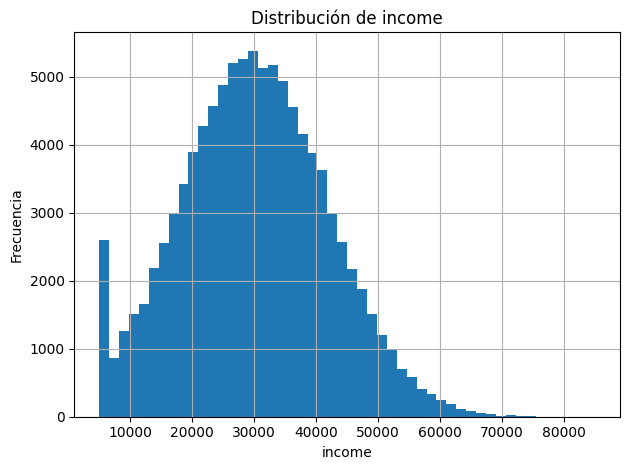

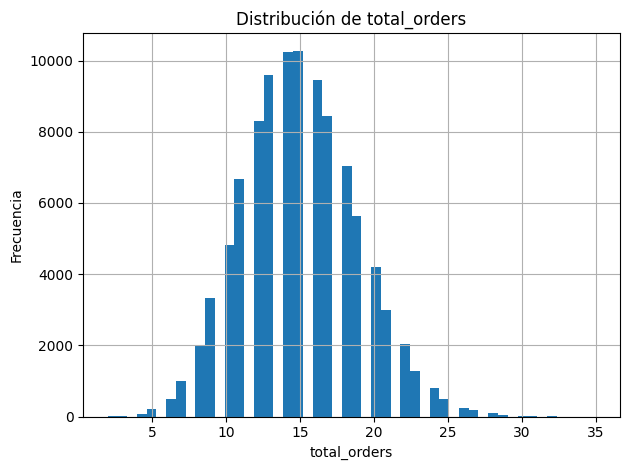

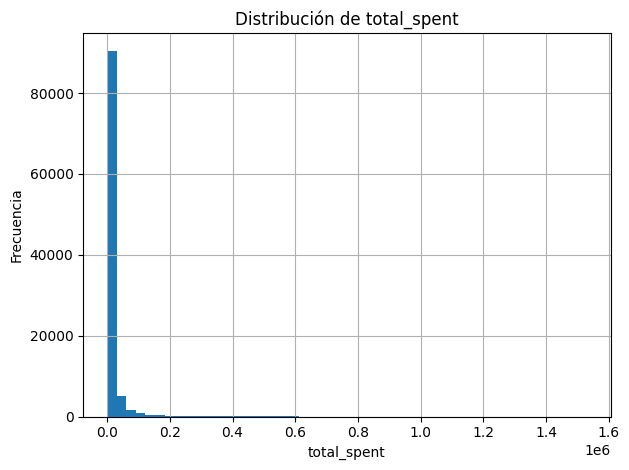

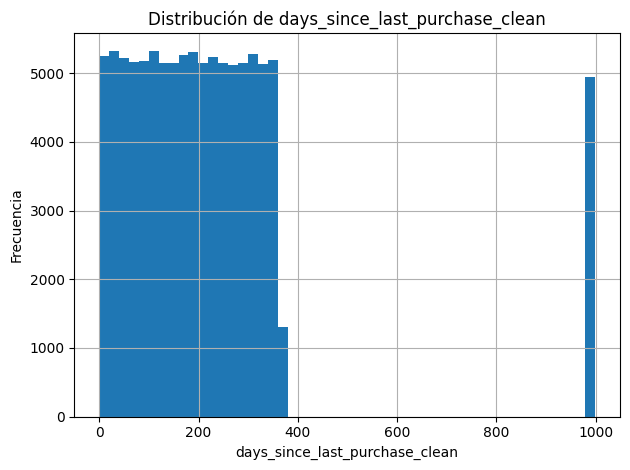

In [20]:
important_features = [
    "income",
    "total_orders",
    "total_spent",
    "days_since_last_purchase_clean",
]

for col in important_features:
    if col not in df_clean.columns:
        continue
    plt.figure()
    df_clean[col].hist(bins=50)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()


### 7.2 Proyección PCA 2D (VIP vs No VIP)


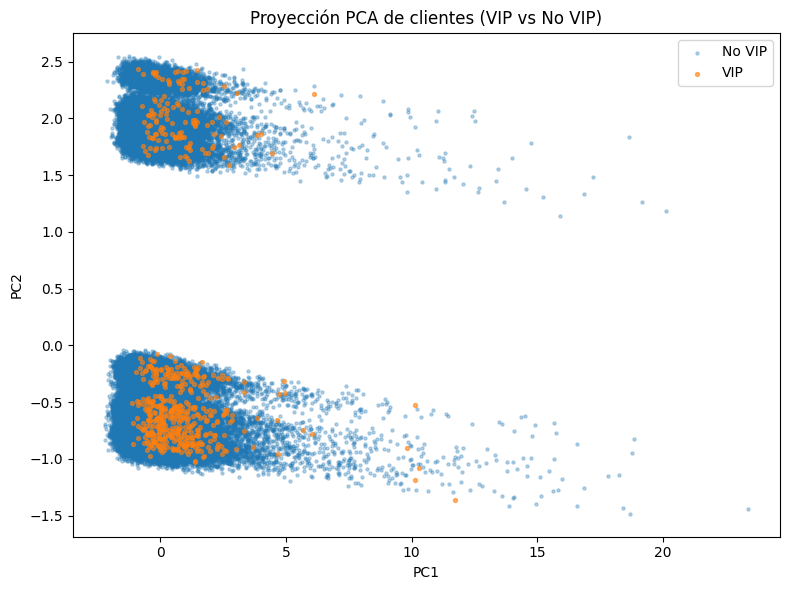

In [21]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_pca = pd.DataFrame({
    "pc1": X_pca[:, 0],
    "pc2": X_pca[:, 1],
    "vip_flag": df_clean["vip_flag"].values,
})

plt.figure(figsize=(8, 6))
mask_vip = df_pca["vip_flag"] == 1

plt.scatter(
    df_pca.loc[~mask_vip, "pc1"],
    df_pca.loc[~mask_vip, "pc2"],
    alpha=0.3,
    s=5,
    label="No VIP",
)
plt.scatter(
    df_pca.loc[mask_vip, "pc1"],
    df_pca.loc[mask_vip, "pc2"],
    alpha=0.6,
    s=8,
    label="VIP",
)

plt.title("Proyección PCA de clientes (VIP vs No VIP)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


## 8. Conclusiones


In [22]:
# Calculamos algunos indicadores para alimentar las conclusiones
vip_ratio = num_vip / num_total

mean_income_vip = df_clean.loc[df_clean["vip_flag"] == 1, "income"].mean()
mean_income_nonvip = df_clean.loc[df_clean["vip_flag"] == 0, "income"].mean()

mean_spent_vip = df_clean.loc[df_clean["vip_flag"] == 1, "total_spent"].mean()
mean_spent_nonvip = df_clean.loc[df_clean["vip_flag"] == 0, "total_spent"].mean()

mean_orders_vip = df_clean.loc[df_clean["vip_flag"] == 1, "total_orders"].mean()
mean_orders_nonvip = df_clean.loc[df_clean["vip_flag"] == 0, "total_orders"].mean()

conclusions_md = """\
### Resumen analítico

- La base de clientes utilizada contiene **{num_total:,} clientes**, de los cuales
  **{num_vip:,}** están marcados como VIP (**{vip_ratio:.2%}** del total).
- Los clientes VIP presentan, en promedio, un ingreso aproximado de
  **${mean_income_vip:,.0f}**, frente a **${mean_income_nonvip:,.0f}** en el resto de clientes.
- En términos de gasto acumulado:
  - VIP: **${mean_spent_vip:,.0f}** en promedio.
  - No VIP: **${mean_spent_nonvip:,.0f}** en promedio.
- Los VIP también muestran una mayor actividad:
  - Órdenes promedio VIP: **{mean_orders_vip:,.1f}**.
  - Órdenes promedio no VIP: **{mean_orders_nonvip:,.1f}**.

### Interpretación de negocio

- El modelo kNN permite encontrar, para un cliente VIP concreto (`{vip_id}`),
  un conjunto de clientes con **perfiles muy similares** (sus lookalikes), lo que abre la puerta a:
    - Extender campañas de **retención o lealtad** hacia clientes que aún no están en el programa,
    - Diseñar campañas de **cross-sell / upsell** sobre grupos con alto potencial de valor.
- La proyección PCA muestra que los clientes VIP tienden a concentrarse en ciertas regiones del espacio
  de características, lo que respalda la lógica de buscar vecinos en dicho espacio en lugar de usar
  reglas simples por edad o ticket promedio.
- Integrar este motor en los flujos de CRM permitiría:
    - Priorizar a quién impactar primero con recursos limitados,
    - Medir el **lift de conversión** al comparar campañas con y sin lookalikes,
    - Reducir el costo por conversión al enfocar los esfuerzos en perfiles de alto potencial.
""".format(
    num_total=num_total,
    num_vip=num_vip,
    vip_ratio=vip_ratio,
    mean_income_vip=mean_income_vip,
    mean_income_nonvip=mean_income_nonvip,
    mean_spent_vip=mean_spent_vip,
    mean_spent_nonvip=mean_spent_nonvip,
    mean_orders_vip=mean_orders_vip,
    mean_orders_nonvip=mean_orders_nonvip,
    vip_id=vip_id,
)

display(Markdown(conclusions_md))


### Resumen analítico

- La base de clientes utilizada contiene **100,000 clientes**, de los cuales
  **567** están marcados como VIP (**0.57%** del total).
- Los clientes VIP presentan, en promedio, un ingreso aproximado de
  **$48,504**, frente a **$29,918** en el resto de clientes.
- En términos de gasto acumulado:
  - VIP: **$31,481** en promedio.
  - No VIP: **$16,489** en promedio.
- Los VIP también muestran una mayor actividad:
  - Órdenes promedio VIP: **22.4**.
  - Órdenes promedio no VIP: **14.9**.

### Interpretación de negocio

- El modelo kNN permite encontrar, para un cliente VIP concreto (`C094641`),
  un conjunto de clientes con **perfiles muy similares** (sus lookalikes), lo que abre la puerta a:
    - Extender campañas de **retención o lealtad** hacia clientes que aún no están en el programa,
    - Diseñar campañas de **cross-sell / upsell** sobre grupos con alto potencial de valor.
- La proyección PCA muestra que los clientes VIP tienden a concentrarse en ciertas regiones del espacio
  de características, lo que respalda la lógica de buscar vecinos en dicho espacio en lugar de usar
  reglas simples por edad o ticket promedio.
- Integrar este motor en los flujos de CRM permitiría:
    - Priorizar a quién impactar primero con recursos limitados,
    - Medir el **lift de conversión** al comparar campañas con y sin lookalikes,
    - Reducir el costo por conversión al enfocar los esfuerzos en perfiles de alto potencial.
